# HAR system - Lincetto Riccardo, Drago Matteo
This notebook runs:
- Classification with null class (One Shot classification);
- Binary classification for activity detection (Two Steps - detection);
- Classification without null class (Two Steps - classification);
- Cascade of the last to methods.

The operations performed here are very similar to those execute in 'main.py', with the exception that here the program is executed for specified user and model.

## Notebook setup
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- task: choose "A" for locomotion classification or "B" for gesture recognition;
- model_name: choose between "Convolutional", "Convolutional1DRecurrent", "Convolutional2DRecurrent" and "ConvolutionalDeepRecurrent";
- data_folder: directory name where '.mat' files are stored;
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window;
- GPU: boolean flag indicatin wheter GPU is present on the machine that executes the code;
- epochs: number of complete sweeps of the data signals during training;
- batch_size: number of forward propagations in the networks between consecutives backpropagations.

In [1]:
subject = 1
task = "A"
model_name = "Convolutional"
data_folder = "./data/full/"
window_size = 15
stride = 5
GPU = True
epochs = 10
batch_size = 32

Here the useful functions are imported.

In [2]:
import preprocessing
import models
import utils
import os
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Riccardo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Differently from 'main.py', all results saved from this notebook are going to be stored in a dedicated folder: './data/notebook/'. For proper execution, this folder needs first to be created.

In [3]:
if not(os.path.exists("./data")):
    os.mkdir("./data")
if not(os.path.exists("./data/notebook")):
    os.mkdir("./data/notebook")

If task A is selected, calssifications in the following notebook are based on the labels of column 0; if instead it's task B, column 6 labels are used.

In [4]:
if task == "A":
    label = 0
elif task == "B":
    label = 6
else:
    print("Error: invalid task.")
print("Task", task, "uses labels column", label)

Task A uses labels column 0


## Classification with null class: One Shot classification
Here classification is performed considering inactivity as a class, alongside with the others. In the case of locomotion classification (task A), this becomes a 5-class problem, while in the case of gesture recognition (task B) the classes become 18. In the following cell are perfomed in order:
- preprocessing;
- model selection;
- model compilation;
- training.

Note that in case "Convolutional2DRecurrent" is the model selected, then the preprocessed data need to be reshaped, adding one dimension; this is automatically done by the code.

In [6]:
# preprocessing
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=data_folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=True,
                                                                                                print_info=False)

# model selection
if model_name == "Convolutional":
    model = models.Convolutional((window_size, n_features), n_classes, print_info=False)
elif model_name == "Convolutional1DRecurrent":
    model = models.Convolutional1DRecurrent((window_size, n_features), n_classes, GPU=GPU, print_info=False)
elif model_name == "Convolutional2DRecurrent":
    model = models.Convolutional2DRecurrent((window_size, n_features, 1), n_classes, GPU=GPU, print_info=False)
    # reshaping for 2D convolutional model
    X_train = X_train.reshape(X_train.shape[0], window_size, n_features, 1)
    X_test = X_test.reshape(X_test.shape[0], window_size, n_features, 1)
elif model_name == "ConvolutionalDeepRecurrent":
    model = models.ConvolutionalDeepRecurrent((window_size, n_features), n_classes, GPU=GPU, print_info=False)
else:
    print("Model not found.")
    break

# model compilation
model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])
save_model_name = task + "_" + model_name + "_OS_" + str(s)
filepath = './data/notebook/'+save_model_name+'.hdf5'
print("Model:", save_model_name, "\nLocation:", filepath, "\n")

# training
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model.fit(x = X_train, 
        y = to_categorical(Y_train), 
        epochs = epochs, 
        batch_size = batch_size,
        verbose = 1,
        validation_data=(X_test, to_categorical(Y_test)),
        callbacks=[checkpointer, lr_reducer])

### Model

In [6]:
oneshot_model = models.ConvolutionalRecurrent((window_size, n_features), n_classes, print_info=False)

oneshot_model.compile(optimizer = Adam(lr=0.001),
                      loss = "categorical_crossentropy", 
                      metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_AOS_1.hdf5', verbose=1, save_best_only=True)

### Training

In [7]:
oneshot_model.fit(x = X_train, 
                  y = to_categorical(Y_train),
                  epochs = 15,
                  batch_size = 128,
                  verbose = 1,
                  callbacks=[checkpointer],
                  validation_data=(X_test, to_categorical(Y_test)),
                  class_weight=class_weights)

Train on 31423 samples, validate on 11505 samples
Epoch 1/15
31423/31423 [==============================] - 10s 328us/step - loss: 0.4909 - acc: 0.8142 - val_loss: 0.3507 - val_acc: 0.8696

Epoch 00001: val_loss improved from inf to 0.35067, saving model to ./data/model_AOS_1.hdf5
Epoch 2/15
31423/31423 [==============================] - 5s 172us/step - loss: 0.3290 - acc: 0.8692 - val_loss: 0.3179 - val_acc: 0.8860

Epoch 00002: val_loss improved from 0.35067 to 0.31791, saving model to ./data/model_AOS_1.hdf5
Epoch 3/15
31423/31423 [==============================] - 5s 173us/step - loss: 0.2827 - acc: 0.8885 - val_loss: 0.3022 - val_acc: 0.9007

Epoch 00003: val_loss improved from 0.31791 to 0.30218, saving model to ./data/model_AOS_1.hdf5
Epoch 4/15
31423/31423 [==============================] - 5s 171us/step - loss: 0.2584 - acc: 0.8982 - val_loss: 0.2984 - val_acc: 0.9000

Epoch 00004: val_loss improved from 0.30218 to 0.29843, saving model to ./data/model_AOS_1.hdf5
Epoch 5/15
31

### Evaluation - passare class_weights a class report

In [8]:
Y_pred = oneshot_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.85      0.89      0.87      2039
          1       0.92      0.90      0.91      3958
          2       0.79      0.80      0.79      2333
          3       0.99      0.99      0.99      2733
          4       0.94      0.84      0.89       442

avg / total       0.90      0.90      0.90     11505

Weighted f1-score: 0.8965743574822785


In [9]:
oneshot_model_best = load_model('./data/model_AOS_1.hdf5')

Y_pred = oneshot_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88      2039
          1       0.92      0.91      0.92      3958
          2       0.83      0.83      0.83      2333
          3       0.97      1.00      0.98      2733
          4       0.91      0.84      0.88       442

avg / total       0.91      0.91      0.91     11505

Weighted f1-score: 0.9073576036830062


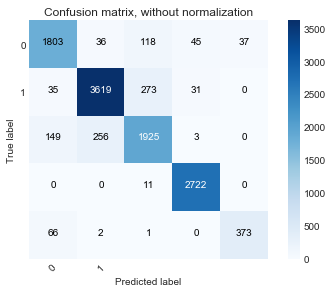

In [10]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

# Two-steps classification
## Activity detection
This model performs a binary classification.
### Preprocessing

In [11]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=True,
                                                                                                null_class=True,
                                                                                                print_info=False)

### Model

In [12]:
detection_model = models.ConvolutionalRecurrent((window_size, n_features), n_classes, print_info=False)

detection_model.compile(optimizer = Adam(lr=0.001),
                        loss = "categorical_crossentropy", 
                        metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_ATSD_1.hdf5', verbose=1, save_best_only=True)

### Training

In [13]:
detection_model.fit(x = X_train, 
                    y = to_categorical(Y_train), 
                    epochs = 15, 
                    batch_size = 128,
                    verbose = 1,
                    callbacks=[checkpointer],
                    validation_data=(X_test, to_categorical(Y_test)),
                    class_weight=class_weights)

Train on 31423 samples, validate on 11505 samples
Epoch 1/15
31423/31423 [==============================] - 9s 272us/step - loss: 0.1381 - acc: 0.9541 - val_loss: 0.1605 - val_acc: 0.9485

Epoch 00001: val_loss improved from inf to 0.16046, saving model to ./data/model_ATSD_1.hdf5
Epoch 2/15
31423/31423 [==============================] - 6s 177us/step - loss: 0.0763 - acc: 0.9738 - val_loss: 0.1470 - val_acc: 0.9538

Epoch 00002: val_loss improved from 0.16046 to 0.14704, saving model to ./data/model_ATSD_1.hdf5
Epoch 3/15
31423/31423 [==============================] - 6s 177us/step - loss: 0.0624 - acc: 0.9780 - val_loss: 0.1562 - val_acc: 0.9537

Epoch 00003: val_loss did not improve
Epoch 4/15
31423/31423 [==============================] - 6s 177us/step - loss: 0.0528 - acc: 0.9809 - val_loss: 0.1403 - val_acc: 0.9553

Epoch 00004: val_loss improved from 0.14704 to 0.14033, saving model to ./data/model_ATSD_1.hdf5
Epoch 5/15
31423/31423 [==============================] - 6s 178us/st

### Evaluation

In [14]:
Y_pred = detection_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.92      0.81      0.86      2039
          1       0.96      0.98      0.97      9466

avg / total       0.95      0.95      0.95     11505

Weighted f1-score: 0.9528960217945623


In [15]:
detection_model_best = load_model('./data/model_ATSD_1.hdf5')

Y_pred = detection_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.95      0.80      0.87      2039
          1       0.96      0.99      0.97      9466

avg / total       0.96      0.96      0.96     11505

Weighted f1-score: 0.9566994574560295


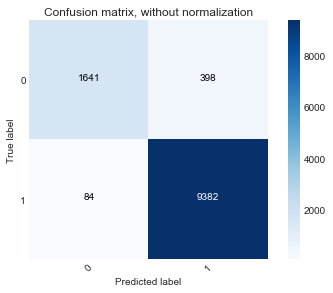

In [16]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [17]:
Y_pred_d = Y_pred

## Activity classification

In [18]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=False,
                                                                                                print_info=False)

### Model

In [19]:
classification_model = models.ConvolutionalRecurrent((window_size, n_features), n_classes, print_info=False)

classification_model.compile(optimizer = Adam(lr=0.001),
                             loss = "categorical_crossentropy", 
                             metrics = ["accuracy"])

checkpointer = ModelCheckpoint(filepath='./data/model_ATSC_1.hdf5', verbose=1, save_best_only=True)

### Training

In [20]:
classification_model.fit(x = X_train,
                         y = to_categorical(Y_train), 
                         epochs = 15, 
                         batch_size = 128,
                         verbose = 1,
                         callbacks=[checkpointer],
                         validation_data=(X_test, to_categorical(Y_test)),
                         class_weight=class_weights)

Train on 27949 samples, validate on 9466 samples
Epoch 1/15
27949/27949 [==============================] - 9s 309us/step - loss: 0.3618 - acc: 0.8527 - val_loss: 0.2699 - val_acc: 0.9145

Epoch 00001: val_loss improved from inf to 0.26991, saving model to ./data/model_ATSC_1.hdf5
Epoch 2/15
27949/27949 [==============================] - 5s 182us/step - loss: 0.2441 - acc: 0.8977 - val_loss: 0.2743 - val_acc: 0.9184

Epoch 00002: val_loss did not improve
Epoch 3/15
27949/27949 [==============================] - 5s 176us/step - loss: 0.2131 - acc: 0.9097 - val_loss: 0.2686 - val_acc: 0.9201

Epoch 00003: val_loss improved from 0.26991 to 0.26859, saving model to ./data/model_ATSC_1.hdf5
Epoch 4/15
27949/27949 [==============================] - 5s 175us/step - loss: 0.1971 - acc: 0.9184 - val_loss: 0.2504 - val_acc: 0.9224

Epoch 00004: val_loss improved from 0.26859 to 0.25044, saving model to ./data/model_ATSC_1.hdf5
Epoch 5/15
27949/27949 [==============================] - 5s 175us/ste

### Evaluation

In [21]:
Y_pred = classification_model.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      3958
          1       0.83      0.90      0.86      2333
          2       0.99      1.00      0.99      2733
          3       1.00      0.85      0.92       442

avg / total       0.93      0.93      0.93      9466

Weighted f1-score: 0.9267518071621716


In [22]:
classification_model_best = load_model('./data/model_ATSC_1.hdf5')

Y_pred = classification_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.92      0.93      0.93      3958
          1       0.86      0.87      0.87      2333
          2       0.99      1.00      0.99      2733
          3       1.00      0.86      0.92       442

avg / total       0.93      0.93      0.93      9466

Weighted f1-score: 0.9305368499675762


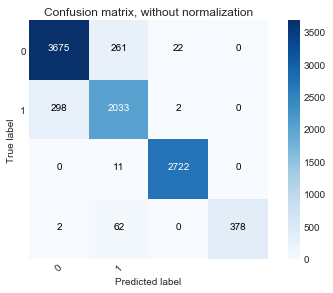

In [23]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

## Cascade of detection and classification
The labels that have to be used for assessment are saved in Y_test_true. The labels predicted by the detection_model are saved instead in Y_pred_d.

In [24]:
print(Y_test_true.shape, Y_pred_d.shape)

(11505,) (11505,)


In [25]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=True,
                                                                                                null_class=True,
                                                                                                print_info=False)

In [26]:
mask = (Y_pred_d == 1)
X_detected = X_test[mask, :, :]
Y_pred_c = classification_model_best.predict_classes(X_detected)
Y_pred_d[mask] = Y_pred_c

In [27]:
print(classification_report(Y_test_true, Y_pred_d))
print("Weighted f1-score:", f1_score(Y_test_true, Y_pred_d, average='weighted'))

             precision    recall  f1-score   support

          0       0.30      0.84      0.44      2039
          1       0.10      0.06      0.08      3958
          2       0.00      0.00      0.00      2333
          3       0.00      0.00      0.00      2733
          4       0.00      0.00      0.00       442

avg / total       0.09      0.17      0.11     11505

Weighted f1-score: 0.1054545307463817


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


One-shot classification instead had:

In [28]:
X_train, Y_train, X_test, Y_test, n_features, n_classes, class_weights = preprocessing.loadData(subject=subject,
                                                                                                label=label,
                                                                                                folder=folder,
                                                                                                window_size=window_size,
                                                                                                stride=stride,
                                                                                                make_binary=False,
                                                                                                null_class=True,
                                                                                                print_info=False)

In [29]:
oneshot_model_best = load_model('./data/model_AOS_1.hdf5')

Y_pred = oneshot_model_best.predict_classes(X_test)
print(classification_report(Y_test, Y_pred))
print("Weighted f1-score:", f1_score(Y_test, Y_pred, average='weighted'))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88      2039
          1       0.92      0.91      0.92      3958
          2       0.83      0.83      0.83      2333
          3       0.97      1.00      0.98      2733
          4       0.91      0.84      0.88       442

avg / total       0.91      0.91      0.91     11505

Weighted f1-score: 0.9073576036830062


# end